In [1]:
## implement the GP with derivative with Gpytorch

# %matplotlib agg

import torch
import gpytorch
import math
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

# %load_ext autoreload
# %autoreload 2

In [3]:
#set up the training data
# here i gonna use a function y = cos(2x) + sin(x) + epsilon as the noisy observation
# derivative observation of the function obtained by: dy/dx = -2sin(2x) + cos(x) + epsilon
# here we assume the noise of the function value and the noise of the derivative are the same

#set the bound for sampling point
lb = 0.0
ub = 5*math.pi

#num train data:
N = 30

In [4]:
train_x = torch.linspace(lb, ub, N).unsqueeze(-1)
train_x.shape

torch.Size([30, 1])

In [5]:
train_y = torch.stack(
    [
        torch.cos(2*train_x) + torch.sin(train_x),
        -2 * torch.sin(2*train_x) + torch.cos(train_x)
    ], -1).squeeze(1)

In [6]:
train_y

tensor([[ 1.0000,  1.0000],
        [ 0.9840, -0.9102],
        [ 0.3223, -1.1870],
        [ 0.0044,  0.1621],
        [ 0.4576,  1.2968],
        [ 1.0673,  0.6167],
        [ 0.8685, -1.4241],
        [-0.3376, -2.7232],
        [-1.6550, -1.7455],
        [-1.9345,  0.8004],
        [-0.9239,  2.6210],
        [ 0.4768,  2.1580],
        [ 1.1225,  0.1368],
        [ 0.7418, -1.2711],
        [ 0.1067, -0.7636],
        [ 0.1067,  0.7636],
        [ 0.7418,  1.2711],
        [ 1.1225, -0.1368],
        [ 0.4768, -2.1580],
        [-0.9239, -2.6210],
        [-1.9345, -0.8004],
        [-1.6550,  1.7455],
        [-0.3376,  2.7232],
        [ 0.8685,  1.4241],
        [ 1.0673, -0.6167],
        [ 0.4576, -1.2968],
        [ 0.0044, -0.1621],
        [ 0.3223,  1.1870],
        [ 0.9840,  0.9102],
        [ 1.0000, -1.0000]])

In [7]:
#nosisy observation
train_y += 0.05 * torch.randn(N, 2)
train_y

tensor([[ 1.0417,  1.0564],
        [ 1.0098, -0.8971],
        [ 0.3699, -1.1730],
        [ 0.0277,  0.2035],
        [ 0.4763,  1.2818],
        [ 1.1239,  0.5724],
        [ 0.9089, -1.4187],
        [-0.1957, -2.6993],
        [-1.6272, -1.8094],
        [-1.9748,  0.8044],
        [-0.9667,  2.6029],
        [ 0.5449,  2.1830],
        [ 1.1796,  0.1439],
        [ 0.6391, -1.2188],
        [ 0.0903, -0.8064],
        [ 0.0571,  0.6733],
        [ 0.7074,  1.2860],
        [ 1.0977, -0.1115],
        [ 0.4445, -2.0792],
        [-1.0007, -2.5966],
        [-1.9538, -0.8917],
        [-1.6767,  1.8166],
        [-0.4039,  2.7865],
        [ 0.7166,  1.3788],
        [ 1.1217, -0.6458],
        [ 0.4156, -1.3879],
        [ 0.0047, -0.0774],
        [ 0.3649,  1.1259],
        [ 0.9120,  0.8746],
        [ 0.9754, -1.0643]])

In [8]:
#set up the model

#define the based class for doing ExactInferene with GP:

#inherit new class for GP with derivative information
class GPWithDervivative(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        # init the new object wiht data and likelihood function
        super(GPWithDervivative, self).__init__(train_x, train_y, likelihood) # getting parant part of the object "GPWithDerivative" and pass the argument to them
        
        self.mean_module = gpytorch.means.ConstantMeanGrad() #select the mean function
        self.base_kernel = gpytorch.kernels.RBFKernelGrad() #select the kernel to use in general (here the kernel does not have scale)
        self.covar_module = gpytorch.kernels.ScaleKernel(self.base_kernel) 
        #scale the output of the kenrel (K_scale = theta_scale_f * K_orig) as formular of RBF kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x) #return the prior dsitribution

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2) # define the likelihood function used
model = GPWithDervivative(train_x, train_y, likelihood)

In [9]:
# if the likelihood is called with a MultivariateNormal (it gonna asusme that input is p(f) -> it return p(y|x))

# import os
# smoke_test = ("CI" in os.environ)
# training_iter = 2 if smoke_test else 50
training_iter = 50 


#find optimal params (set model to train mode)
model.train() # learn the hyperparams of the kernel
likelihood.train() #set to train since we need learn the noise varaince

#use adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)


# log los (marginal log likelihood) as loss func
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model) # exact marginal likelihood model -> p(f|x) -> p(y|f)*p(f|x) -> marginal

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x) #prior ~ N(0, K)
    loss = -mll(output, train_y) #p(y|x)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 1.440   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 1.402   lengthscale: 0.744   noise: 0.644
Iter 3/50 - Loss: 1.372   lengthscale: 0.796   noise: 0.598
Iter 4/50 - Loss: 1.345   lengthscale: 0.846   noise: 0.554
Iter 5/50 - Loss: 1.319   lengthscale: 0.888   noise: 0.513
Iter 6/50 - Loss: 1.293   lengthscale: 0.917   noise: 0.474
Iter 7/50 - Loss: 1.265   lengthscale: 0.931   noise: 0.437
Iter 8/50 - Loss: 1.234   lengthscale: 0.931   noise: 0.403
Iter 9/50 - Loss: 1.203   lengthscale: 0.923   noise: 0.370
Iter 10/50 - Loss: 1.172   lengthscale: 0.909   noise: 0.340
Iter 11/50 - Loss: 1.142   lengthscale: 0.895   noise: 0.312
Iter 12/50 - Loss: 1.113   lengthscale: 0.885   noise: 0.286
Iter 13/50 - Loss: 1.083   lengthscale: 0.883   noise: 0.261
Iter 14/50 - Loss: 1.053   lengthscale: 0.888   noise: 0.239
Iter 15/50 - Loss: 1.021   lengthscale: 0.901   noise: 0.218
Iter 16/50 - Loss: 0.989   lengthscale: 0.921   noise: 0.199
Iter 17/50 - Loss: 0.957   length

In [10]:
# Set into eval mode
# model.train()
model.eval()
likelihood.eval()

MultitaskGaussianLikelihood(
  (raw_task_noises_constraint): GreaterThan(1.000E-04)
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

In [11]:
# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(lb, ub, 500)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

In [12]:
predict_mean_np = mean.detach().numpy()

In [13]:
predict_mean_np.shape

(500, 2)

In [14]:
type(predict_mean_np)

numpy.ndarray

In [15]:
predict_mean_np[:,0].shape

(500,)

In [16]:
test_x_input = test_x.detach().numpy()
test_x_input.shape

(500,)

In [17]:
type(test_x_input)

numpy.ndarray

In [18]:
lower_np = lower.detach().numpy()
upper_np = upper.detach().numpy()

In [65]:
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(12, 6))

# Make predictions
with torch.no_grad(), gpytorch.settings.max_cg_iterations(50):
    test_x = torch.linspace(lb, ub, 500)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

    # Plot training data
    y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), '*')
    
    # Predictive mean as blue line
    y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
    
    # confidence
    y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
    
    y1_ax.legend(['Observed Values', 'Mean', 'Confidence'])
    y1_ax.set_title('Function values')
    
    # training data
    y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), '+')
    
    # Predictive mea
    y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
    
    # confidence
    y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
    
    y2_ax.legend(['Observed Derivatives', 'Mean', 'Confidence'])
    y2_ax.set_title('Derivatives')

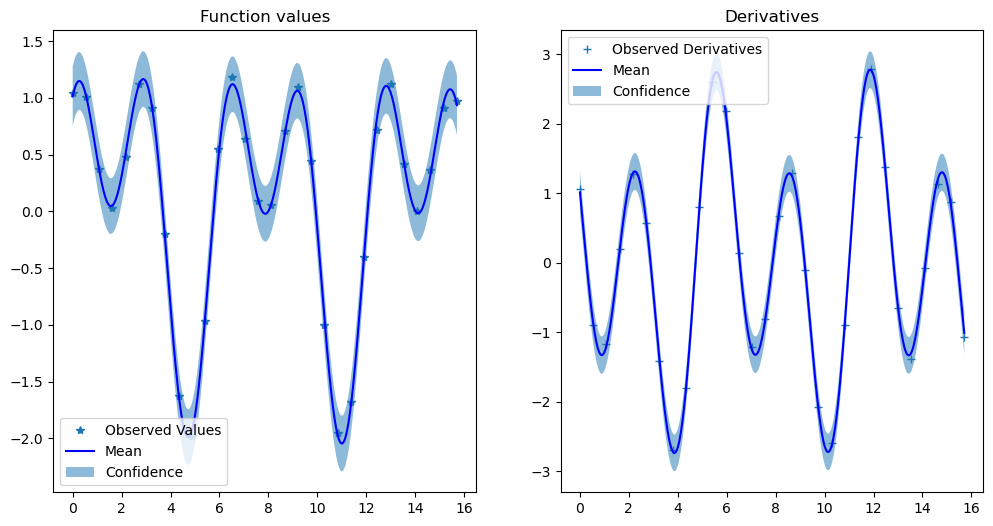

In [67]:
plt.show()